In [1]:
import xarray as xr
import xrft
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from dask.utils import SerializableLock
from dask.distributed import Client
client = Client(scheduler_file='../schedule_file')
client

<Client: scheduler='tcp://10.43.4.162:8786' processes=1 cores=48>

In [3]:
ddir = '/rigel/ocp/users/ra2697/LLC/llc_4320_agulhas/'
ds = xr.open_mfdataset(ddir + '*.0000010*.nc')
ds

<xarray.Dataset>
Dimensions:   (i: 2160, i_g: 2160, j: 2160, j_g: 2160, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 5)
Coordinates:
  * j         (j) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g       (j_g) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * i         (i) int64 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 ...
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g       (i_g) int64 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 ...
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face      int64 1
  * time      (time) timedelta64[ns] 3 days 00:00:00 3 days 01:00:00 ...
    iter      (time) int64 10368 10512 10656 10800 10944
Data variables:
    PhiBot    (time, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [4]:
ds.nbytes / 1e9

43.296840096

In [5]:
ds.chunks

Frozen(SortedKeysDict({'i_g': (2160,), 'j_g': (2160,), 'i': (2160,), 'k': (90,), 'k_l': (90,), 'j': (2160,), 'time': (1, 1, 1, 1, 1)}))

In [10]:
w_sq_profile = (ds.W**2).mean(dim=('time', 'j', 'i'))
w_sq_profile

<xarray.DataArray 'W' (k_l: 90)>
dask.array<mean_ag..., shape=(90,), dtype=float32, chunksize=(1,)>
Coordinates:
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1

In [11]:
%time w_sq_profile.load()

KeyboardInterrupt: 

In [8]:
v_fft = xrft.dft(ds.V, dim=['i'], shift=False)
pow_spec = (v_fft*v_fft.conj()).isel(freq_i=slice(0,len(ds.i)//2)).mean(dim=('j_g','time')).astype('f8')
pow_spec

/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: pandas.core.common.is_timedelta64_dtype is deprecated. import from the public API: pandas.api.types.is_timedelta64_dtype instead
  if __name__ == '__main__':


<xarray.DataArray 'fft-9e7d1a1d29332e86fbdbb892db44b8fd' (k: 90, freq_i: 1080)>
dask.array<astype-..., shape=(90, 1080), dtype=float64, chunksize=(90, 1080)>
Coordinates:
  * k               (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    freq_i_spacing  float64 0.000463
  * freq_i          (freq_i) float64 0.0 0.000463 0.0009259 0.001389 ...

In [9]:
pow_spec.load()

<xarray.DataArray 'fft-9e7d1a1d29332e86fbdbb892db44b8fd' (k: 90, freq_i: 1080)>
array([[  4.166368e-11,   1.154729e+04,   2.355524e+03, ...,   2.052357e-02,
          2.150409e-02,   2.133854e-02],
       [  3.382015e-11,   7.379178e+03,   2.100006e+03, ...,   2.072421e-02,
          2.177537e-02,   2.153859e-02],
       [  2.892492e-11,   5.620923e+03,   1.999421e+03, ...,   2.080840e-02,
          2.191047e-02,   2.161839e-02],
       ..., 
       [  8.784211e-16,   2.695469e-01,   2.679084e-01, ...,   4.659943e-03,
          4.640745e-03,   4.456825e-03],
       [  1.074702e-17,   2.436451e-03,   2.437934e-03, ...,   1.762975e-04,
          1.762814e-04,   1.762714e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   0.000000e+00,
          0.000000e+00,   0.000000e+00]])
Coordinates:
  * k               (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    freq_i_spacing  float64 0.000463
  * freq_i          (freq_i) float64 0.0 0.000463 0.0009259 0.00138

(0.01, 10000.0)

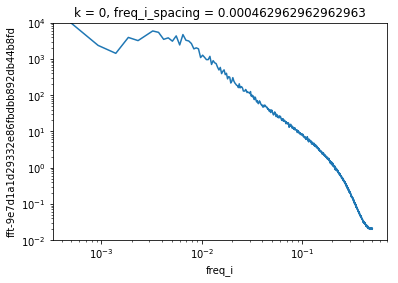

In [11]:
fig, ax = plt.subplots()
pow_spec[0].plot(ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-2,1e4])

In [72]:
from dask.dot import dot_graph

RuntimeError: Drawing dask graphs requires the `graphviz` python library and the `graphviz` system library to be installed.